- pickrate of operators
- pickrate vs winrate plot
- winrate overall of all defender rounds
- winrate overall of all attacker rounds


In [1]:
import pandas as pd
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from tqdm import tqdm

In [2]:
df = pd.read_csv(
    "./data/data_reduced.csv",
    usecols={
        "dateid",
        "platform",
        "gamemode",
        "mapname",
        "matchid",
        "roundnumber",
        "objectivelocation",
        "winrole",
        "endroundreason",
        "roundduration",
        "clearancelevel",
        "skillrank",
        "role",
        "team",
        "haswon",
        "operator",
        "nbkills",
        "isdead"
    },
    dtype={
        # "dateid": "int64",
        "platform": "category",
        "gamemode": "category",
        "mapname": "category",
        "matchid": "int64",
        "roundnumber": "int64",
        "objectivelocation": "category",
        "winrole": "category",
        "endroundreason": "category",
        "roundduration": "int64",
        "clearancelevel": "int64",
        "skillrank": "category",
        "role": "category",
        "team": "int64",
        "haswon": "boolean",
        "operator": "category",
        "nbkills": "int64",
        "isdead": "boolean"
    },
    parse_dates=["dateid"]
)

In [3]:
df.shape

(3889573, 18)

In [4]:
df.head()

,dateid,platform,gamemode,mapname,matchid,roundnumber,objectivelocation,winrole,endroundreason,roundduration,clearancelevel,skillrank,role,team,haswon,operator,nbkills,isdead
0,2017-02-12,PC,BOMB,BARTLETT_U.,1529883301,6,ROWING_MUSEUM-TROPHY_ROOM,Attacker,DefendersEliminated,246,147,Platinum,Attacker,1,True,JTF2-BUCK,1,True
1,2017-02-12,PC,BOMB,BARTLETT_U.,1529883301,2,READING_ROOM-LIBRARY,Defender,AttackersEliminated,231,40,Unranked,Defender,0,True,GIGN-ROOK,0,True
2,2017-02-12,PC,BOMB,BARTLETT_U.,1529883301,4,KITCHEN-PIANO_ROOM,Attacker,DefendersEliminated,233,60,Gold,Defender,0,False,G.E.O.-MIRA,0,True
3,2017-02-12,PC,BOMB,BARTLETT_U.,1529883301,6,ROWING_MUSEUM-TROPHY_ROOM,Attacker,DefendersEliminated,246,40,Unranked,Defender,0,False,GIGN-ROOK,0,True
4,2017-02-12,PC,BOMB,BARTLETT_U.,1529883301,7,CLASSROOM-LIBRARY,Attacker,DefendersEliminated,168,56,Unranked,Defender,0,False,SWAT-CASTLE,0,True


In [5]:
def print_size(df):
    print(round(sys.getsizeof(df) / (1024 ** 2), 2), "mb")

print_size(df)

255.96 mb


### Calculate the Team Winrates

In [6]:
df_role_winrates = df.groupby(["matchid", "roundnumber"])["winrole"].first().reset_index(name="winrole")
df_role_winrates

,matchid,roundnumber,winrole
0,147541,1,Attacker
1,147541,2,Attacker
2,147541,3,Defender
3,147541,4,Attacker
4,147541,5,Defender
...,...,...,...
402805,4294898609,5,Defender
402806,4294898609,6,Attacker
402807,4294898609,7,Defender
402808,4294898609,8,Defender


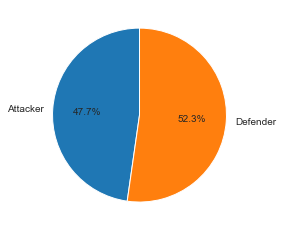

In [7]:
attacker_winrate = df_role_winrates.loc[df_role_winrates["winrole"] == "Attacker"]["winrole"].count() / df_role_winrates["winrole"].count()
defender_winrate = df_role_winrates.loc[df_role_winrates["winrole"] == "Defender"]["winrole"].count() / df_role_winrates["winrole"].count()

df_plot_role_winrates = pd.DataFrame({"team": ["Attacker", "Defender"], "winrate": [attacker_winrate, defender_winrate]})
plt.pie(x=df_plot_role_winrates["winrate"], labels=df_plot_role_winrates["team"], autopct='%1.1f%%', startangle=90)
plt.show()

In [8]:
df["dateid"].nunique()

95

In [9]:
df["matchid"].nunique()

69155

In [6]:
df["skillrank"] = df["skillrank"].cat.reorder_categories(["Unranked", "Copper", "Bronze", "Silver", "Gold", "Platinum", "Diamond"])
df["skillrank"].dtype

CategoricalDtype(categories=['Unranked', 'Copper', 'Bronze', 'Silver', 'Gold', 'Platinum',
                  'Diamond'],
, ordered=False)

## skill rank distribution

In [8]:
df_rank_distribution = df["skillrank"].value_counts(sort=False).reset_index(name="count").rename(columns={"index": "skillrank"})
df_rank_distribution

,skillrank,count
0,Unranked,352817
1,Copper,267611
2,Bronze,374394
3,Silver,667432
4,Gold,1485947
5,Platinum,672003
6,Diamond,69369


C:\Users\marti\anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  


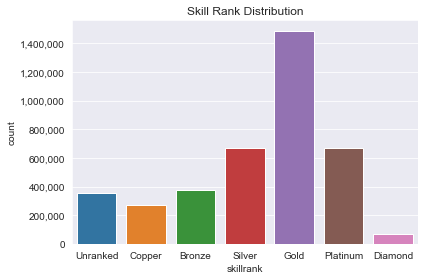

In [12]:
sns.barplot(data=df_rank_distribution, y="count", x="skillrank")
# my_plot.set_xticklabels(rotation=30, ha='right')
# after plotting the data, format the labels
current_values = plt.gca().get_yticks()
# using format string '{:.0f}' here but you can choose others
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.title("Skill Rank Distribution")
plt.tight_layout()
plt.savefig("././plots/skillrank-distribution.pdf")
plt.show()

## Round Duration per skillrank

In [13]:
df_plot = df.groupby("skillrank")["roundduration"].median().reset_index(name="median_roundduration")
df_plot

,skillrank,median_roundduration
0,Unranked,196.0
1,Copper,189.0
2,Bronze,192.0
3,Silver,194.0
4,Gold,198.0
5,Platinum,199.0
6,Diamond,191.0


In [14]:
df.loc[df["roundduration"] > 210].shape

(1470742, 18)

In [15]:
df.loc[df["roundduration"] <= 210].shape

(2418831, 18)

<AxesSubplot:xlabel='skillrank', ylabel='median_roundduration'>

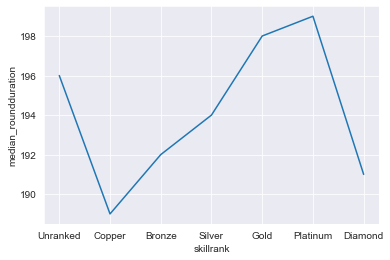

In [16]:
sns.lineplot(data=df_plot, x="skillrank", y="median_roundduration")

In [32]:
df["roundduration_corrected"] = df["roundduration"] - 30
df["roundduration_corrected"].describe()

count    3.889573e+06
mean     1.617953e+02
std      4.098731e+01
min     -2.400000e+01
25%      1.350000e+02
50%      1.660000e+02
75%      1.930000e+02
max      1.273900e+04
Name: roundduration_corrected, dtype: float64

<AxesSubplot:xlabel='skillrank', ylabel='roundduration'>

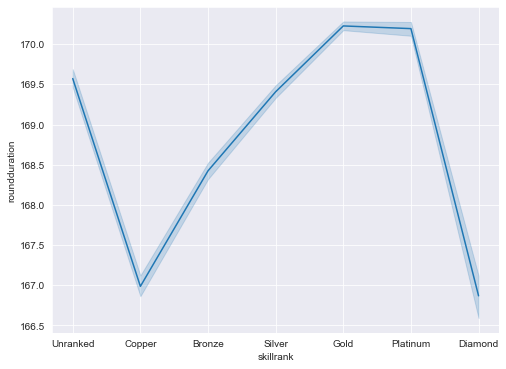

In [35]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=df.loc[(df["roundduration_corrected"] < 181) & (df["roundduration_corrected"] >= 0)], x="skillrank", y="roundduration")

<AxesSubplot:xlabel='roundduration', ylabel='skillrank'>

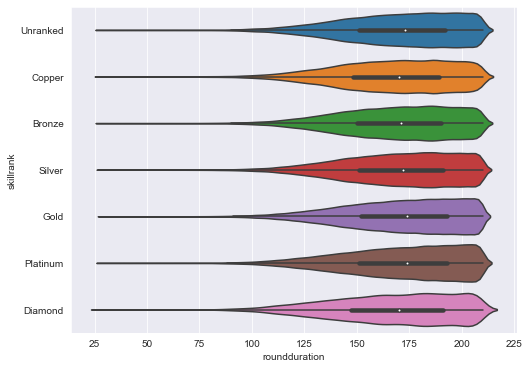

In [36]:
plt.figure(figsize=(8, 6))
sns.violinplot(data=df.loc[(df["roundduration_corrected"] < 181) & (df["roundduration_corrected"] >= 0)], x="roundduration", y="skillrank")

<AxesSubplot:xlabel='skillrank', ylabel='roundduration'>

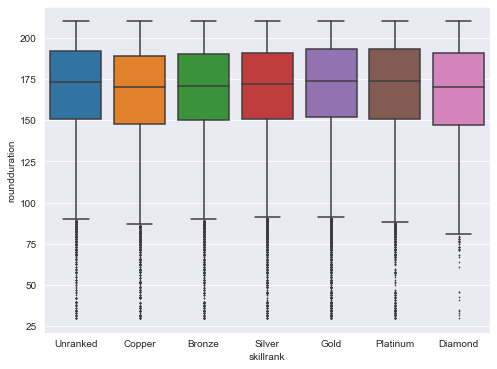

In [37]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df.loc[(df["roundduration_corrected"] < 181) & (df["roundduration_corrected"] >= 0)], x="skillrank", y="roundduration", fliersize=.8)

In [ ]:
sns.lineplot(data=df.loc[df["skillrank"] == "Diamond"], y="roundduration", x="dateid")

In [ ]:
sns.lineplot(data=df.loc[df["skillrank"] == "Copper"], y="roundduration", x="dateid")

In [ ]:
sns.lineplot(data=df.loc[df["skillrank"] == "Gold"], y="roundduration", x="dateid")

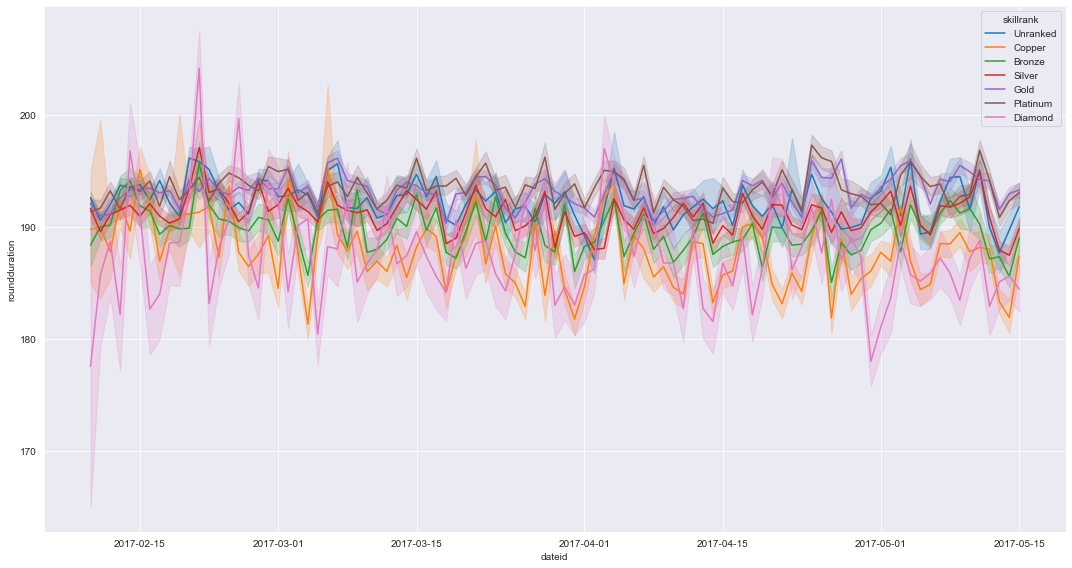

In [21]:
plt.figure(figsize=(15, 8))
sns.lineplot(data=df, y="roundduration", x="dateid", hue="skillrank")
plt.savefig("././plots/rounddurations.pdf")
plt.tight_layout()
plt.show()

In [19]:
df.groupby("skillrank")["roundduration"].describe()

,count,mean,std,min,25%,50%,75%,max
skillrank,,,,,,,,
Unranked,352817.0,192.235686,40.813156,6.0,165.0,196.0,224.0,5110.0
Copper,267611.0,187.234837,48.063993,7.0,159.0,189.0,221.0,7530.0
Bronze,374394.0,189.547129,40.148260,7.0,162.0,192.0,222.0,3650.0
Silver,667432.0,191.048823,39.451161,6.0,164.0,194.0,223.0,5318.0
Gold,1485947.0,192.956266,41.194181,6.0,166.0,198.0,224.0,12769.0
Platinum,672003.0,193.263502,39.397324,7.0,167.0,199.0,224.0,4595.0
Diamond,69369.0,187.375470,39.604856,9.0,159.0,191.0,220.0,2390.0


## end of round reason

In [7]:
df_endroundreason = df.groupby("skillrank")["endroundreason"].value_counts(normalize=True).reset_index(name="percentage")
df_endroundreason

,skillrank,level_1,percentage
0,Unranked,DefendersEliminated,0.458260
1,Unranked,AttackersEliminated,0.379415
2,Unranked,BombExploded,0.078006
3,Unranked,DefuserDeactivated,0.063225
4,Unranked,BombDeactivated_OneBomb,0.017601
...,...,...,...
58,Diamond,BombDeactivated_OneBomb,0.008505
59,Diamond,AllTeamsDead,0.001398
60,Diamond,AttackersSurrendered,0.001096
61,Diamond,DefendersSurrendered,0.000750


In [51]:
frames = []
for index, tbl in df_endroundreason.groupby("skillrank"):
    # df = pd.DataFrame(columns=tbl["level_1"])
    # df["skillrank"] = index
    # frames.append(df)
    df = tbl[["level_1", "percentage"]].T.reset_index()
    df.columns = df.iloc[0]
    df = df.drop(df.index[0])
    df["Defenders Eliminated"] = df["DefendersEliminated"]
    df["Attackers Eliminated"] = df["AttackersEliminated"]
    df["Defender Objective fulfilled"] = df["BombExploded"] + df["DefuserDeactivated"]
    df["Attacker Objective fulfilled"] = df["BombDeactivated_OneBomb"]
    df["Rest"] = df["AttackersSurrendered"] + df["AllTeamsDead"] + df["DefendersSurrendered"]
    # df = df.drop(columns=["level_1"])
    df = df[["Defenders Eliminated", "Attackers Eliminated", "Defender Objective fulfilled", "Attacker Objective fulfilled"]]
    df["skillrank"] = index
    # print(df)
    frames.append(df)

df_endroundreason_plot = pd.concat(frames)
df_endroundreason_plot

,Defenders Eliminated,Attackers Eliminated,Defender Objective fulfilled,Attacker Objective fulfilled,skillrank
1,0.45826,0.379415,0.141232,0.017601,Unranked
1,0.470384,0.366696,0.135704,0.022723,Copper
1,0.464965,0.373008,0.138154,0.020484,Bronze
1,0.461237,0.377847,0.138826,0.018711,Silver
1,0.455174,0.390336,0.13467,0.016332,Gold
1,0.45965,0.404384,0.120403,0.01218,Platinum
1,0.469432,0.423777,0.095042,0.008505,Diamond


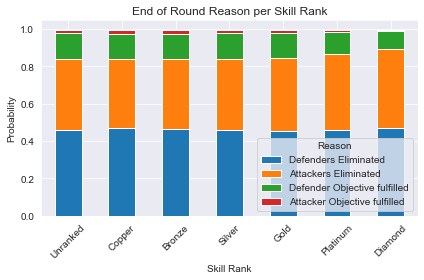

In [62]:
df_endroundreason_plot.plot(kind="bar", x="skillrank", stacked=True)
plt.title("End of Round Reason per Skill Rank")
plt.legend(title="Reason", loc="lower right")
plt.ylabel("Probability")
plt.xlabel("Skill Rank")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("./plots/endroundreasons.pdf")
plt.show()

In [49]:
df_endroundreason_all = df["endroundreason"].value_counts(normalize=True).reset_index()
df_endroundreason_all["endroundreason_percentage"] = round(df_endroundreason_all["endroundreason"] * 100, 2)
df_endroundreason_all

,index,endroundreason,endroundreason_percentage
0,DefendersEliminated,0.459511,45.95
1,AttackersEliminated,0.386931,38.69
2,BombExploded,0.068962,6.90
3,DefuserDeactivated,0.064251,6.43
4,BombDeactivated_OneBomb,0.016838,1.68
5,AttackersSurrendered,0.001365,0.14
6,DefendersSurrendered,0.001061,0.11
7,AllTeamsDead,0.001056,0.11
8,NoEnemies,0.000025,0.00


In [52]:
df.loc[df["endroundreason"] == "BombDeactivated_OneBomb"]["winrole"].value_counts(normalize=True)

Attacker    1.0
Defender    0.0
Name: winrole, dtype: float64

In [61]:
df.groupby("skillrank")["nbkills"].mean()

skillrank
Unranked    0.570840
Copper      0.643113
Bronze      0.673232
Silver      0.690506
Gold        0.721507
Platinum    0.784941
Diamond     0.903646
Name: nbkills, dtype: float64

## Calculate the survivability

In [70]:
df_plot = df.groupby("skillrank")["isdead"].value_counts(normalize=True).reset_index(name="percentage")
df_plot["survived"] = ~df_plot["isdead"]
df_plot

,skillrank,isdead,percentage,survived
0,Unranked,True,0.740296,False
1,Unranked,False,0.259704,True
2,Copper,True,0.727930,False
3,Copper,False,0.272070,True
4,Bronze,True,0.714939,False
5,Bronze,False,0.285061,True
6,Silver,True,0.711121,False
7,Silver,False,0.288879,True
8,Gold,True,0.704359,False
9,Gold,False,0.295641,True


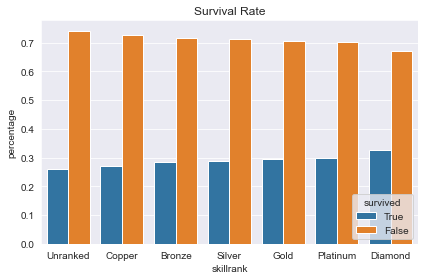

In [84]:
sns.barplot(data=df_plot, x="skillrank", y="percentage", hue="survived", hue_order=[True, False])
plt.legend(title="survived", loc="lower right")
plt.title("Survival Rate")
plt.tight_layout()
plt.savefig("./plots/survivability.pdf")
plt.show()

In [15]:
df["mapname"].value_counts()

HOUSE               255100
KAFE_DOSTOYEVSKY    252848
CLUB_HOUSE          250387
CHALET              248992
OREGON              248659
KANAL               247234
HEREFORD_BASE       245882
PLANE               244267
SKYSCRAPER          243444
CONSULATE           240936
BANK                240288
BORDER              238590
BARTLETT_U.         237370
YACHT               237142
FAVELAS             236969
COASTLINE           221465
Name: mapname, dtype: int64

In [16]:
df["mapname"].nunique()

16

## Play Days

In [39]:
df_plot_nbmatches = df.groupby("dateid", as_index=False)["matchid"].nunique().rename(columns={"matchid": "nbmatches"})
df_plot_nbmatches["day_name"] = df_plot_nbmatches["dateid"].dt.day_name()
df_plot_nbmatches["weekday"] = df_plot_nbmatches["dateid"].dt.weekday
df_plot_nbmatches

,dateid,nbmatches,day_name,weekday
0,2017-02-10,1030,Friday,4
1,2017-02-11,1372,Saturday,5
2,2017-02-12,1370,Sunday,6
3,2017-02-13,986,Monday,0
4,2017-02-14,829,Tuesday,1
...,...,...,...,...
90,2017-05-11,502,Thursday,3
91,2017-05-12,612,Friday,4
92,2017-05-13,800,Saturday,5
93,2017-05-14,799,Sunday,6


In [45]:
df_plot_nbmatches.groupby("weekday")["nbmatches"].describe()

,count,mean,std,min,25%,50%,75%,max
weekday,,,,,,,,
0,14.0,691.142857,123.230776,561.0,602.25,645.5,771.75,986.0
1,13.0,605.307692,120.078714,362.0,547.00,583.0,650.00,829.0
2,13.0,618.769231,102.664627,453.0,572.00,606.0,628.00,834.0
3,13.0,599.538462,112.431176,451.0,527.00,579.0,672.00,862.0
4,14.0,718.071429,145.831021,436.0,643.50,686.5,790.50,1030.0
5,14.0,905.714286,157.512602,786.0,821.50,853.5,931.75,1372.0
6,14.0,934.071429,159.069150,799.0,826.50,862.5,982.50,1370.0


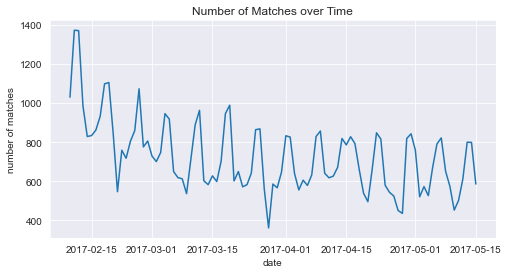

In [42]:
plt.figure(figsize=(8, 4))
sns.lineplot(data=df_plot_nbmatches, x="dateid", y="nbmatches")
plt.title("Number of Matches over Time")
plt.xlabel("date")
plt.ylabel("number of matches")
plt.savefig("./plots/number_of_matches_per_day.pdf")
plt.show()

In [22]:
# df["weekday"] = df["dateid"].dt.day_name().astype("category")
df["weekday_numeric"] = df["dateid"].dt.weekday
# df_nbmatches_per_day = df.groupby("dateid", as_index=False)["matchid"].count().rename(columns={"matchid": "nbmatches"})
# df_nbmatches_per_day

In [23]:
df.groupby("skillrank")["weekday_numeric"].value_counts(normalize=True)

skillrank  weekday_numeric
Unranked   5                  0.201524
           6                  0.190835
           4                  0.167004
           0                  0.134894
           2                  0.103745
           1                  0.103683
           3                  0.098314
Copper     6                  0.182410
           5                  0.175198
           4                  0.144647
           0                  0.143428
           3                  0.121546
           2                  0.116595
           1                  0.116176
Bronze     6                  0.190708
           5                  0.176667
           0                  0.141728
           4                  0.137772
           2                  0.119673
           1                  0.118896
           3                  0.114556
Silver     6                  0.192277
           5                  0.182351
           0                  0.141709
           4                  0.14075

In [25]:
df_weekday_plot = df.groupby("skillrank")["weekday_numeric"].value_counts(normalize=True).reset_index(name="nbmatches").rename(columns={"level_1": "weekday"})
df_weekday_plot

,skillrank,weekday_numeric,nbmatches
0,Unranked,5,0.201524
1,Unranked,6,0.190835
2,Unranked,4,0.167004
3,Unranked,0,0.134894
4,Unranked,2,0.103745
5,Unranked,1,0.103683
6,Unranked,3,0.098314
7,Copper,6,0.182410
8,Copper,5,0.175198
9,Copper,4,0.144647


<AxesSubplot:xlabel='weekday_numeric', ylabel='nbmatches'>

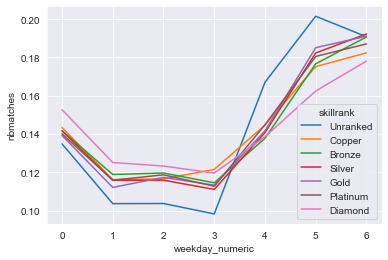

In [63]:
# for role, tbl in df_weekday_plot.groupby("skillrank"):
#     plt.figure(figsize=(15,8))
#     sns.pointplot(x="weekday", y="nbmatches", hue="skillrank", data=tbl,
#                   legend=False, size=5, aspect=2.5)
#     plt.legend(loc=9, bbox_to_anchor=(0.5, -0.2), ncol=5)
#     plt.title(role + ' Operators\' Win Rate Based on Rank')
#     plt.xlabel('Rank')
#     plt.ylabel('Win Ratio')
# plt.show()
# order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
# plt.figure(figsize=(15, 8))
sns.lineplot(data=df_weekday_plot.sort_values(by="weekday_numeric"), x="weekday_numeric", y="nbmatches", hue="skillrank")


In [13]:
# sns.lineplot(data=df, x="dateid", y=df["dateid"].nunique()

SyntaxError: unexpected EOF while parsing (<ipython-input-13-fd3c5a969d28>, line 1)

In [25]:
df_objectives = pd.read_csv("./data/datadump_s5_summary_objectives.csv", dtype={
    "dateid": "int64",
    "platform": "category",
    "gamemode": "category",
    "mapname": "category",
    "objectivelocation": "category",
    "skillrank": "category",
    "role": "category",
    "operator": "category",
    "nbkills": "int64",
    "nbwins": "int64",
    "nbdeaths": "int64",
    "nbpicks": "int64",
})
df_objectives.shape

(8785348, 12)

In [26]:
df_objectives.head()

,platform,dateid,gamemode,mapname,objectivelocation,skillrank,role,operator,nbwins,nbkills,nbdeaths,nbpicks
0,PC,20170210,BOMB,BANK,EXECUTIVE_LOUNGE-CEO_OFFICE,Bronze,Attacker,G.E.O.-JACKAL,0,0,1,1
1,PC,20170210,BOMB,BANK,EXECUTIVE_LOUNGE-CEO_OFFICE,Bronze,Attacker,GIGN-MONTAGNE,1,0,2,3
2,PC,20170210,BOMB,BANK,EXECUTIVE_LOUNGE-CEO_OFFICE,Bronze,Attacker,GSG9-IQ,0,0,1,1
3,PC,20170210,BOMB,BANK,EXECUTIVE_LOUNGE-CEO_OFFICE,Bronze,Attacker,JTF2-BUCK,0,0,1,1
4,PC,20170210,BOMB,BANK,EXECUTIVE_LOUNGE-CEO_OFFICE,Bronze,Attacker,SAS-THATCHER,0,0,1,1


In [27]:
print_size(df_objectives)

402.18 mb


In [28]:
df_map_operator = df_objectives.groupby(["mapname", "operator"], as_index=False)[['nbwins', 'nbkills', 'nbdeaths', 'nbpicks']].sum()
df_map_operator

,mapname,operator,nbwins,nbkills,nbdeaths,nbpicks
0,BANK,BOPE-CAPITAO,43342,59347,65445,90290
1,BANK,BOPE-CAVEIRA,142567,196837,193628,265097
2,BANK,G.E.O.-JACKAL,117301,179952,168240,239529
3,BANK,G.E.O.-MIRA,81676,99557,103303,153763
4,BANK,GIGN-DOC,78621,94073,102277,148859
...,...,...,...,...,...,...
555,YACHT,SWAT-ASH,184151,297372,250423,355660
556,YACHT,SWAT-CASTLE,52463,59472,77938,107544
557,YACHT,SWAT-PULSE,89467,125819,134204,180387
558,YACHT,SWAT-RESERVE,5476,6453,8757,11578


In [29]:
df_map_operator["win_ratio"] = df_map_operator["nbwins"] / df_map_operator["nbpicks"]
df_map_operator["kd_ratio"] = df_map_operator["nbkills"] / df_map_operator["nbdeaths"]
df_map_operator

,mapname,operator,nbwins,nbkills,nbdeaths,nbpicks,win_ratio,kd_ratio
0,BANK,BOPE-CAPITAO,43342,59347,65445,90290,0.480031,0.906823
1,BANK,BOPE-CAVEIRA,142567,196837,193628,265097,0.537792,1.016573
2,BANK,G.E.O.-JACKAL,117301,179952,168240,239529,0.489715,1.069615
3,BANK,G.E.O.-MIRA,81676,99557,103303,153763,0.531181,0.963738
4,BANK,GIGN-DOC,78621,94073,102277,148859,0.528158,0.919786
...,...,...,...,...,...,...,...,...
555,YACHT,SWAT-ASH,184151,297372,250423,355660,0.517773,1.187479
556,YACHT,SWAT-CASTLE,52463,59472,77938,107544,0.487828,0.763068
557,YACHT,SWAT-PULSE,89467,125819,134204,180387,0.495973,0.937520
558,YACHT,SWAT-RESERVE,5476,6453,8757,11578,0.472966,0.736896


In [30]:
df_map_role = df_objectives.groupby(["mapname", "role"], as_index=False)[['nbwins', 'nbkills', 'nbdeaths', 'nbpicks']].sum()
df_map_role["win_ratio"] = df_map_role["nbwins"] / df_map_role["nbpicks"]
df_map_role["kd_ratio"] = df_map_role["nbkills"] / df_map_role["nbdeaths"]
df_map_role

,mapname,role,nbwins,nbkills,nbdeaths,nbpicks,win_ratio,kd_ratio
0,BANK,Attacker,1291581,1887730,1870105,2675126,0.482811,1.009425
1,BANK,Defender,1447407,1864148,1896745,2699571,0.536162,0.982814
2,BARTLETT_U.,Attacker,1241273,1815176,1852964,2628860,0.472172,0.979607
3,BARTLETT_U.,Defender,1452915,1848806,1829067,2654339,0.547374,1.010792
4,BORDER,Attacker,1341549,1914519,1879312,2667897,0.502849,1.018734
5,BORDER,Defender,1387612,1874116,1929287,2692283,0.515403,0.971403
6,CHALET,Attacker,1477725,1999576,1794663,2694804,0.548361,1.114179
7,CHALET,Defender,1273391,1790878,2010119,2717417,0.468603,0.890931
8,CLUB_HOUSE,Attacker,1402386,1972144,1843063,2696048,0.520164,1.070036
9,CLUB_HOUSE,Defender,1351948,1837548,1979480,2718838,0.497252,0.928298


<AxesSubplot:xlabel='mapname', ylabel='role'>

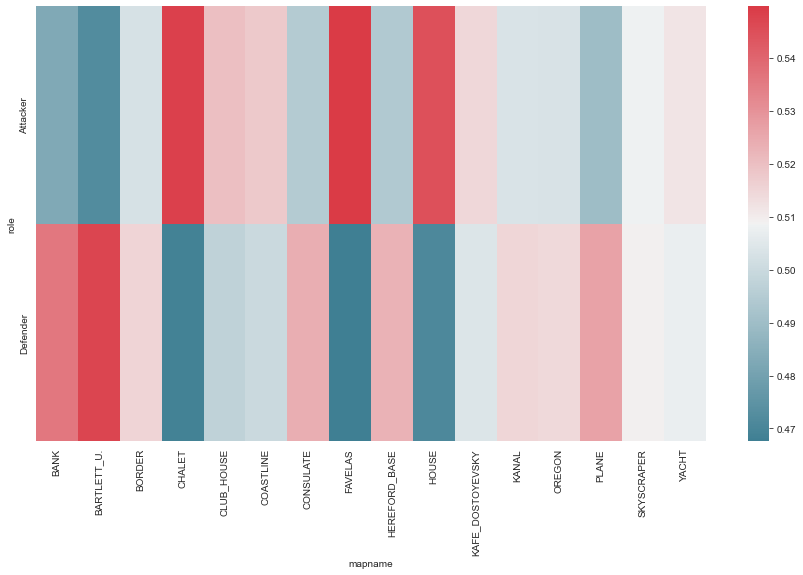

In [22]:
plt.figure(figsize=(15, 8))
sns.heatmap(df_map_role.pivot(index="role", columns="mapname", values="win_ratio"), cmap=sns.diverging_palette(220,10, as_cmap=True))

In [ ]:
# df.groupby(["matchid", "roundnumber"])["winrole"].first().reset_index(name="winner_team")

In [ ]:
# df.head(1000).groupby(["matchid", "roundnumber"], as_index=False)["winrole"].first()

In [ ]:
# df.groupby(["dateid", "matchid", "roundnumber", "team"])["operator"].apply(list).reset_index(name="operators")